In [1]:
import datetime as dt
import findspark
import numpy as np
import logging
import matplotlib.pyplot as plt
import mlflow
import os
import pandas as pd
import pickle
import pyspark
import random
import sys
import time
import warnings

from collections import Counter
from IPython import get_ipython
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier as pysparkRF
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.utils import parallel_backend
from tqdm import tqdm
from typing import List

tqdm.pandas()
get_ipython().run_line_magic('matplotlib', '')
warnings.filterwarnings("ignore")

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s.%(msecs)03d %(levelname)s %(module)s - %(funcName)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
)

dt_format = "%Y-%m-%d"
dt_format_full = f"{dt_format} %H:%M:%S"

findspark.init()
findspark.find()

spark = (
    SparkSession.builder
    .appName("train_model")
    .master("yarn")
    .config("spark.executor.cores", "2")
    .config("spark.hadoop.fs.s3.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
    .getOrCreate()
)
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.sparkContext.setLogLevel('ERROR')

Using matplotlib backend: <object object at 0x7fd9b4c5e6b0>


OpenJDK 64-Bit Server VM warning: Option UseConcMarkSweepGC was deprecated in version 9.0 and will likely be removed in a future release.
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/lib/spark/jars/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/hadoop/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2023-03-20 19:58:11,232 WARN util.Utils: Your hostname, mlops-airflow resolves to a loopback address: 127.0.1.1; using 10.128.0.16 instead (on interface eth0)
2023-03-20 19:58:11,232 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023-03-20 19:58:15,170 WARN u

## Read source data

In [2]:
date_from = "2023-03-19"
date_to = "2023-03-19"
hdfs_host = "rc1a-dataproc-m-jyttnmhm6xuzhmkj.mdb.yandexcloud.net"
hdfs_dirs_input = ["/fraud-data-processed/2023-03-19.parquet"]

dt_from = dt.datetime.strptime(f"{date_from} 00:00:00", dt_format_full)
dt_to = dt.datetime.strptime(f"{date_to} 23:59:59", dt_format_full)


def read_transactions_df(spark: SparkSession, dt_from: dt.datetime, dt_to: dt.datetime, hdfs_dirs_input: List[str]):
    logging.info(f"Reading {hdfs_dirs_input}")
    # df = spark.read.schema(schema).parquet(*hdfs_dirs_input)
    df = spark.read.parquet(*hdfs_dirs_input)
    logging.info(f"Filtering data using window {dt_from} <= dt <= {dt_to}")
    df = df.filter((df.tx_datetime >= dt_from) & (df.tx_datetime <= dt_to))
    logging.info(f"Rows to process: {df.count()}")
    
    return df

In [3]:
transactions_df = read_transactions_df(spark, dt_from, dt_to, hdfs_dirs_input)
transactions_df.printSchema()

2023-03-20 19:58:29.262 INFO 4106497 - read_transactions_df: Reading ['/fraud-data-processed/2023-03-19.parquet']
2023-03-20 19:58:36.632 INFO 4106497 - read_transactions_df: Filtering data using window 2023-03-19 00:00:00 <= dt <= 2023-03-19 23:59:59
2023-03-20 19:58:44.720 INFO 4106497 - read_transactions_df: Rows to process: 192718


root
 |-- transaction_id: long (nullable = true)
 |-- tx_datetime: timestamp (nullable = true)
 |-- customer_id: long (nullable = true)
 |-- terminal_id: long (nullable = true)
 |-- tx_amount: double (nullable = true)
 |-- tx_time_seconds: long (nullable = true)
 |-- tx_time_days: long (nullable = true)
 |-- tx_fraud: long (nullable = true)
 |-- tx_fraud_scenario: long (nullable = true)
 |-- tx_during_weekend: integer (nullable = true)
 |-- tx_during_night: integer (nullable = true)
 |-- customer_id_nb_tx_1day_window: long (nullable = true)
 |-- customer_id_avg_amount_1day_window: double (nullable = true)
 |-- customer_id_nb_tx_3day_window: long (nullable = true)
 |-- customer_id_avg_amount_3day_window: double (nullable = true)
 |-- customer_id_nb_tx_7day_window: long (nullable = true)
 |-- customer_id_avg_amount_7day_window: double (nullable = true)
 |-- terminal_id_nb_tx_1day_window: long (nullable = true)
 |-- terminal_id_risk_1day_window: double (nullable = true)
 |-- terminal_id_n

## Split train and test data

In [4]:
from pyspark.sql.functions import explode, split, lit
from typing import Tuple


def get_train_test_df(df, fraction: float) -> Tuple:
    logging.info(f"Splitting train & test with {fraction=}")
    fractions = df.select("tx_fraud").distinct().withColumn("fraction", lit(0.8)).rdd.collectAsMap()
    
    train_df = df.sampleBy("tx_fraud", fractions)
    logging.info(f"Train: {train_df.count()=}")
    train_frauds = train_df.filter(train_df.tx_fraud == 1).count()
    train_frauds_fraction = train_frauds / train_df.count()
    logging.info(f"{train_frauds=}, {train_frauds_fraction*100:.2f}%")
    
    test_df = df.subtract(train_df)
    logging.info(f"Test: {test_df.count()=}")
    test_frauds = test_df.filter(test_df.tx_fraud == 1).count()
    test_frauds_fraction = test_frauds / test_df.count()
    logging.info(f"{test_frauds=}, {test_frauds_fraction*100:.2f}%")
    
    return train_df, test_df

In [5]:
train_df, test_df = get_train_test_df(transactions_df, 0.8)

2023-03-20 19:58:44.834 INFO 1373549324 - get_train_test_df: Splitting train & test with fraction=0.8
2023-03-20 19:58:53.686 INFO 1373549324 - get_train_test_df: Train: train_df.count()=154230
2023-03-20 19:58:57.189 INFO 1373549324 - get_train_test_df: train_frauds=2384, 1.55%
2023-03-20 19:59:07.722 INFO 1373549324 - get_train_test_df: Test: test_df.count()=38488
2023-03-20 19:59:20.570 INFO 1373549324 - get_train_test_df: test_frauds=663, 1.72%


## Pipeline

In [6]:
input_features = ["tx_amount", "tx_during_weekend", "tx_during_night",
                  "customer_id_nb_tx_1day_window", "customer_id_avg_amount_1day_window",
                  "customer_id_nb_tx_3day_window", "customer_id_avg_amount_3day_window",
                  "customer_id_nb_tx_7day_window", "customer_id_avg_amount_7day_window",
                  "terminal_id_nb_tx_1day_window", "terminal_id_risk_1day_window",
                  "terminal_id_nb_tx_3day_window", "terminal_id_risk_3day_window",
                  "terminal_id_nb_tx_7day_window", "terminal_id_risk_7day_window"]

output_feature = "tx_fraud"

In [7]:
from pyspark.ml import Pipeline

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.ml.tuning import CrossValidator, TrainValidationSplit, ParamGridBuilder


# convert dataframe to vector
vec_assembler = VectorAssembler(inputCols=input_features, outputCol="features")

In [8]:
# create PCA (when we have a lot of columns or features)
# pca = PCA(k=5, inputCol="va", outputCol="features")

In [9]:
rf_classifier = RandomForestClassifier(labelCol=output_feature, featuresCol="features")

In [10]:
# pipeline = Pipeline(stages=[vec_assembler, pca, rf_classifier])
pipeline = Pipeline(stages=[vec_assembler, rf_classifier])

## Tuning Hyperparameters

In [11]:
class RandomGridBuilder:
    '''Grid builder for random search. Sets up grids for use in CrossValidator in Spark using values randomly sampled from user-provided distributions.
    Distributions should be provided as lambda functions, so that the numbers are generated at call time.
  
    Parameters:
      num_models: Integer (Python) - number of models to generate hyperparameters for
      seed: Integer (Python) - seed (optional, default is None)
  
    Returns:
      param_map: list of parameter maps to use in cross validation.
  
    Example usage:
      from pyspark.ml.classification import LogisticRegression
      lr = LogisticRegression()
      paramGrid = RandomGridBuilder(2)\
                 .addDistr(lr.regParam, lambda: np.random.rand()) \
                 .addDistr(lr.maxIter, lambda : np.random.randint(10))\
                 .build()
  
      Returns similar output as Spark ML class ParamGridBuilder and can be used in its place. The above paramGrid provides random hyperparameters for 2 models.
      '''

    def __init__(self, num_models, seed=None):
        self._param_grid = {}
        self.num_models = num_models
        self.seed = seed

    def addDistr(self, param, distr_generator):
        '''Add distribution based on dictionary generated by function passed to addDistr.'''

        if 'pyspark.ml.param.Param' in str(type(param)):
            self._param_grid[param] = distr_generator
        else:
            raise TypeError('param must be an instance of Param')

        return self

    def build(self):
        param_map = []
        for n in range(self.num_models):
            if self.seed:
                # Set seeds for both numpy and random in case either is used for the random distribution
                np.random.seed(self.seed + n)
                random.seed(self.seed + n)
            param_dict = {}
            for param, distr in self._param_grid.items():
                param_dict[param] = distr()
            param_map.append(param_dict)

        return param_map

In [12]:
evaluator = BinaryClassificationEvaluator(labelCol=output_feature)

param_grid = (RandomGridBuilder(12)
    .addDistr(rf_classifier.maxDepth, lambda: np.random.randint(1, 16))
    .addDistr(rf_classifier.maxBins,  lambda: np.random.randint(20, 100))
    .addDistr(rf_classifier.numTrees, lambda: np.random.randint(5, 50))
    .addDistr(rf_classifier.impurity, lambda: np.random.choice(['gini', 'entropy']))
    .build())

validator = CrossValidator(estimator=pipeline,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator,
                           numFolds=10,
                           parallelism=2)

In [13]:
model_cv = validator.fit(train_df)

## Best model

In [14]:
best_model = model_cv.bestModel
final_predictions = best_model.transform(train_df)
evaluator.evaluate(final_predictions)

0.9985467341315518

In [15]:
best_model_params = {
    "maxDepth": best_model.stages[-1]._java_obj.getMaxDepth(),
    "maxBins": best_model.stages[-1]._java_obj.getMaxBins(),
    "numTrees": best_model.stages[-1]._java_obj.getNumTrees(),
    "impurity": best_model.stages[-1]._java_obj.getImpurity(),
}
best_model_params

{'maxDepth': 13, 'maxBins': 79, 'numTrees': 37, 'impurity': 'gini'}

In [16]:
best_model.stages

[VectorAssembler_c9aad202481e,
 RandomForestClassificationModel: uid=RandomForestClassifier_22f331aa93b1, numTrees=37, numClasses=2, numFeatures=15]

## Model Evalution

In [17]:
def evaluate(model, train_df, test_df) -> Tuple:
    train_pred = model.transform(train_df)
    train_acc = evaluator.evaluate(train_pred)
    
    test_pred = model.transform(test_df)
    test_acc = evaluator.evaluate(test_pred)
    
    logging.info(f"Accuracy: {train_acc=:.4f}, {test_acc=:.4f}")
    
    return train_pred, test_pred, train_acc, test_acc

In [18]:
train_pred, test_pred, train_acc, test_acc = evaluate(model_cv, train_df, test_df)

2023-03-20 20:11:14.099 INFO 2708430108 - evaluate: Accuracy: train_acc=0.9985, test_acc=0.9976


## Precision - Recall

In [19]:
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report


def report_cm(y_train, y_test, y_train_pred, y_test_pred, classes):
    figure, axes = plt.subplots(1, 2, figsize=(10,5))

    train_cm = confusion_matrix(y_train, y_train_pred)
    train_cm_df = pd.DataFrame(train_cm, index=classes, columns=classes)
    ax = sns.heatmap(train_cm_df, annot=True, ax=axes[1], square=True, fmt="d")
    ax.set_title("Train CM")

    test_cm = confusion_matrix(y_test, y_test_pred)
    test_cm_df = pd.DataFrame(test_cm, index=classes, columns=classes)
    ax = sns.heatmap(test_cm_df, annot=True, ax=axes[0], square=True, fmt="d")
    ax.set_title("Test CM")

    print('\n' + '-' * 20 + 'Training Performance' + '-' * 20 + '\n')
    print(classification_report(y_train, y_train_pred, target_names=classes))
    print('acc: ', metrics.accuracy_score(y_train, y_train_pred))
    print('precision: ', metrics.precision_score(y_train, y_train_pred))
    print('recall: ', metrics.recall_score(y_train, y_train_pred))

    print('\n' + '-' * 20 + 'Testing Performance' + '-' * 20 + '\n')
    print(classification_report(y_test, y_test_pred, target_names=classes))
    print('acc: ', metrics.accuracy_score(y_test, y_test_pred))
    print('precision: ', metrics.precision_score(y_test, y_test_pred))
    print('recall: ', metrics.recall_score(y_test, y_test_pred))

In [20]:
y_train = train_pred.select(output_feature).toPandas().apply(lambda x: x[0], 1).values.tolist()
y_train_pred = train_pred.select("prediction").toPandas().apply(lambda x: x[0], 1).values.tolist()

y_test = test_pred.select(output_feature).toPandas().apply(lambda x: x[0], 1).values.tolist()
y_test_pred = test_pred.select("prediction").toPandas().apply(lambda x: x[0], 1).values.tolist()


--------------------Training Performance--------------------

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00    151846
       fraud       1.00      0.87      0.93      2384

    accuracy                           1.00    154230
   macro avg       1.00      0.94      0.97    154230
weighted avg       1.00      1.00      1.00    154230

acc:  0.9980613369642741
precision:  1.0
recall:  0.8745805369127517

--------------------Testing Performance--------------------

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     37825
       fraud       1.00      0.90      0.95       663

    accuracy                           1.00     38488
   macro avg       1.00      0.95      0.97     38488
weighted avg       1.00      1.00      1.00     38488

acc:  0.9983111619205987
precision:  1.0
recall:  0.9019607843137255


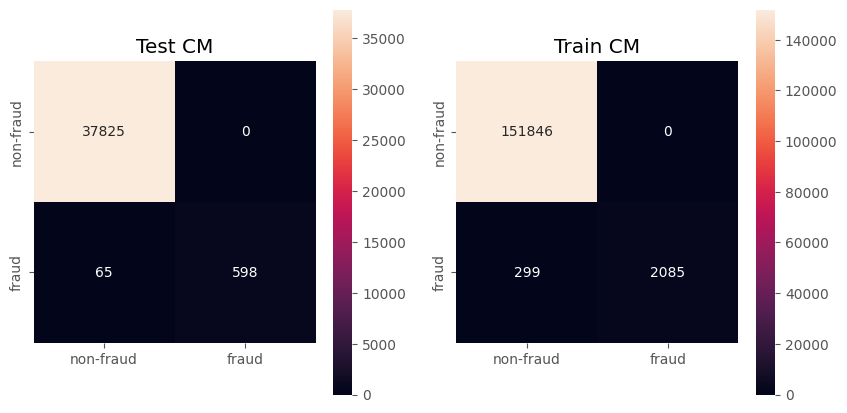

In [21]:
report_cm(y_train, y_test, y_train_pred, y_test_pred, ["non-fraud", "fraud"])

## MLFlow

In [23]:
from mlflow.tracking import MlflowClient


os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["MLFLOW_TRACKING_URI"] = "http://10.128.0.16:5000/"

mlflow_client = MlflowClient()
mlflow.set_experiment("antifraud_rf")
run_name = f"antifraud_rf_pipeline {dt.datetime.now()}"
output_artifact = "antifraud_rf_model"

with mlflow.start_run(run_name=run_name) as active_run:
    run_id = active_run.info.run_id
    logging.info(f"Logging params to MLflow run {run_id} ...")
    mlflow.log_params(best_model_params)
    mlflow.log_param("date_from", dt_from)
    mlflow.log_param("date_to", dt_to)
    mlflow.log_param("dataset_size", transactions_df.count())
    mlflow.log_param("train_size", train_df.count())
    mlflow.log_param("test_size", test_df.count())

    logging.info(f"Logging metrics to MLflow run {run_id} ...")
    roc_auc = round(test_acc, 4)
    precision = round(metrics.precision_score(y_test, y_test_pred), 4)
    recall = round(metrics.recall_score(y_test, y_test_pred), 4)
    logging.info(f"{roc_auc=}, {precision=}, {recall=}")

    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    
    logging.info("Saving model ...")
    mlflow.spark.save_model(best_model, output_artifact)

    logging.info("Exporting/logging model ...")
    mlflow.spark.log_model(best_model, output_artifact)
    logging.info("Done")

2023-03-20 20:23:33.778 INFO 2133204636 - <module>: Logging params to MLflow run 4071168823964a67b10859071e04913b ...
2023-03-20 20:23:40.277 INFO 2133204636 - <module>: Logging metrics to MLflow run 4071168823964a67b10859071e04913b ...
2023-03-20 20:23:40.365 INFO 2133204636 - <module>: roc_auc=0.9976, precision=1.0, recall=0.902
2023-03-20 20:23:40.474 INFO 2133204636 - <module>: Saving model ...
2023-03-20 20:24:33.681 INFO 2133204636 - <module>: Exporting/logging model ...
2023/03/20 20:25:49 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp8lvimmga, flavor: spark), fall back to return ['pyspark==3.0.3']. Set logging level to DEBUG to see the full traceback.
2023-03-20 20:25:49.557 INFO credentials - load: Found credentials in shared credentials file: ~/.aws/credentials
2023-03-20 20:25:49.805 INFO 2133204636 - <module>: Done


In [24]:
spark.stop()